In [ ]:
SEED = 100

# Cross-validation [NO AFFECT, this notebook removed k-folding cross validation]
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 5          # Number of users for validation split
N_TEST_USERS = 5         # Number of users for test split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 1              # Print frequency

# Optimisation
LEARNING_RATE = 0.0001   # Learning rate
BATCH_SIZE = 512         # Batch size
WINDOW_SIZE = 200        # Input window size
STRIDE = 50              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'LSTM'        # Type of RNN architecture ['RNN', 'LSTM', 'GRU']
BIDIRECTIONAL = False    # Bidirectional RNN

# Regularisation
NOISE_STD_DEV = 0.03     # Data Augmentation: Added noise on training dataset
DROPOUT_RATE = 0.3       # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0.01         # L2 penalty

import torch.nn as nn
CRITERION = nn.CrossEntropyLoss() # Training utilities

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
import random
import torch
import os
from itertools import product



from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

PyTorch version: 2.9.0+cu128
Device: cuda


In [144]:
df_train = pd.read_csv('pirate_pain_train.csv')

float_cols = df_train.select_dtypes(include=['float64']).columns
for col in float_cols:
    df_train[col] = df_train[col].astype(np.float32)

df_train.head()


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765108e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437265e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [145]:
counts = df_train.groupby('sample_index')['time'].count().reset_index(name='n_timestamps')
counts = counts.sort_values('sample_index')  

avg_ts = counts['n_timestamps'].mean()
print(f"Average number of timestamps per sample_index: {avg_ts:.2f}")

print(counts)

Average number of timestamps per sample_index: 160.00
     sample_index  n_timestamps
0               0           160
1               1           160
2               2           160
3               3           160
4               4           160
..            ...           ...
656           656           160
657           657           160
658           658           160
659           659           160
660           660           160

[661 rows x 2 columns]


In [146]:
# %%
def build_fixed_sequences(df_features, df_labels, feature_cols, joint_cols, label_map, 
                          window=200, stride=50):
    """
    Builds fixed-size, overlapping sequences from the dataset.
    This function normalizes each sample individually before windowing.
    """
    dataset = []
    labels = []
    n_features = len(feature_cols)

    print(f"Building fixed sequences with window={window}, stride={stride}...")

    # Iterate over unique sample indices
    for sid in df_features['sample_index'].unique():
        
        # 1. Get features
        temp_features = df_features[df_features['sample_index'] == sid].sort_values('time')[feature_cols].values
        
        # 2. Get label
        label_str = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
        label_numeric = label_map[label_str]

        # 3. Normalize
        temp_features_tensor = torch.FloatTensor(temp_features)
        joint_data = temp_features_tensor[:, :len(joint_cols)]
        joint_min = joint_data.min(dim=0)[0]
        joint_max = joint_data.max(dim=0)[0]
        joint_range = joint_max - joint_min
        joint_range[joint_range == 0] = 1
        normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
        temp_features_tensor[:, :len(joint_cols)] = normalized_joints
        temp_features_normalized = temp_features_tensor.numpy()

        # 4. Apply padding (from your original logic)
        padding_len = window - len(temp_features_normalized) % window
        
        # --- BUG FIX: Remove the 'if padding_len == window' line ---
        # This was the bug. The original logic was correct.
        
        padding = np.zeros((padding_len, n_features), dtype='float32')
        temp_features_padded = np.concatenate((temp_features_normalized, padding))

        # 5. Apply windowing logic
        idx = 0
        while idx + window <= len(temp_features_padded):
            dataset.append(temp_features_padded[idx:idx + window])
            labels.append(label_numeric)
            idx += stride

    dataset = np.array(dataset, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    return dataset, labels

In [147]:
df_labels = pd.read_csv('pirate_pain_train_labels.csv')
df_labels.head()

df_joint_00 = df_train[['sample_index', 'time', 'joint_00']].copy()
df_joint_00 = df_joint_00.merge(df_labels, on='sample_index', how='left')



In [148]:
# %%
# --- 1. Define feature columns and label map ---
joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
feature_cols = joint_cols + pain_cols
input_size = len(feature_cols)

# Create label map
unique_labels = sorted(df_labels['label'].unique())
label_map = {label: i for i, label in enumerate(unique_labels)}
num_classes = len(label_map)

print(f"Feature columns: {input_size}")
print(f"Label map: {label_map}")

# --- 2. Build all sequences ---
# We use the constants defined in your notebook (WINDOW_SIZE=200, STRIDE=50)
X_all_windows, y_all_windows = build_fixed_sequences(
    df_train, df_labels, feature_cols, joint_cols, label_map,
    window=WINDOW_SIZE,
    stride=STRIDE
)

print(f"Original samples: {len(df_labels)}")
print(f"Total windows created: {len(X_all_windows)}")
print(f"Shape of X: {X_all_windows.shape}") # (num_windows, WINDOW_SIZE, num_features)
print(f"Shape of y: {y_all_windows.shape}") # (num_windows,)

# --- 3. Split into train/validation sets ---
X_train, X_val, y_train, y_val = train_test_split(
    X_all_windows,
    y_all_windows,
    test_size=0.2,
    random_state=SEED,
    stratify=y_all_windows  # Stratify on the new window labels
)

print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Val shapes  : X={X_val.shape}, y={y_val.shape}")

# %%
# --- 4. Create new, flexible Dataset ---
# This dataset can now add noise *only* during training

class PainDataset(Dataset):
    def __init__(self, X, y, is_train=False, n_joint_cols=0, noise_level=0.01):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
        # --- New parameters for noise ---
        self.is_train = is_train
        self.n_joint_cols = n_joint_cols
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        # Use .clone() to ensure we don't modify the original, clean data
        x_sample = self.X[idx].clone() 
        y_sample = self.y[idx]
        
        # --- Add noise *only* if it's the training set ---
        if self.is_train and self.noise_level > 0:
            # 1. Create noise
            # Shape: (window_size, num_joint_features)
            noise = torch.randn(x_sample.shape[0], self.n_joint_cols) * self.noise_level
            
            # 2. Add noise ONLY to the joint columns
            x_sample[:, :self.n_joint_cols] = x_sample[:, :self.n_joint_cols] + noise.to(x_sample.device)
            
        return x_sample, y_sample

# --- 5. Create new DataLoaders ---

# Get the number of joint columns
n_joint_cols = len(joint_cols) 

# Create the TRAINING dataset *with noise enabled*
train_dataset = PainDataset(
    X_train, y_train, 
    is_train=True, 
    n_joint_cols=n_joint_cols, 
    noise_level=NOISE_STD_DEV
)

# Create the VALIDATION dataset *with noise disabled*
# This is critical! You want a stable, clean metric for validation.
val_dataset = PainDataset(
    X_val, y_val, 
    is_train=False
)



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check a batch to see the effect
print(f"Noise level (std): {NOISE_STD_DEV}")
print(f"Original X_train[0] first joint, first 5 steps:\n {X_train[0, :5, 0]}")

x_batch, y_batch = next(iter(train_loader))
print(f"\nNoisy batch[0] first joint, first 5 steps:\n {x_batch[0, :5, 0]}")

Feature columns: 35
Label map: {'high_pain': 0, 'low_pain': 1, 'no_pain': 2}
Building fixed sequences with window=200, stride=50...
Original samples: 661
Total windows created: 661
Shape of X: (661, 200, 35)
Shape of y: (661,)

Train shapes: X=(528, 200, 35), y=(528,)
Val shapes  : X=(133, 200, 35), y=(133,)
Noise level (std): 0.03
Original X_train[0] first joint, first 5 steps:
 [-0.09461689  0.01702583  0.6403575  -0.35634392 -0.44900668]

Noisy batch[0] first joint, first 5 steps:
 tensor([-0.1291, -0.1497, -0.4234,  0.0291,  0.1719])
Original samples: 661
Total windows created: 661
Shape of X: (661, 200, 35)
Shape of y: (661,)

Train shapes: X=(528, 200, 35), y=(528,)
Val shapes  : X=(133, 200, 35), y=(133,)
Noise level (std): 0.03
Original X_train[0] first joint, first 5 steps:
 [-0.09461689  0.01702583  0.6403575  -0.35634392 -0.44900668]

Noisy batch[0] first joint, first 5 steps:
 tensor([-0.1291, -0.1497, -0.4234,  0.0291,  0.1719])


In [149]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [150]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.batch_norm = nn.BatchNorm1d(input_size)


        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Get a sample sequence to determine max sequence length
max_seq_len = max(len(seq) for seq in sequences)

# Create model and display architecture with parameter count
input_size = len(feature_cols)  # Number of features (joints + pain surveys)
num_classes = len(label_map)    # Number of unique labels

# Create model with correct input size
rnn_model = RecurrentClassifier(
    input_size=input_size,      # Number of input features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)

# Call recurrent_summary with correct input shape
recurrent_summary(rnn_model, input_size=(max_seq_len, input_size))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 160, 128], [2, -1, 128]] 54,144         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,531
Trainable params: 54,531
Non-trainable params: 0
-------------------------------------------------------------------------------


In [151]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)


            # Check loss for NaN
            if torch.isnan(loss):
                print(f"NaN loss at batch {batch_idx}")
                print(f"Input range: [{inputs.min():.4f}, {inputs.max():.4f}]")
                print(f"Logits range: [{logits.min():.4f}, {logits.max():.4f}]")
                continue

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [152]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [153]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [154]:
import os
import copy
from itertools import chain

def k_fold_cross_validation(df_train, df_labels, epochs, criterion, device,
                            k, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            rnn_type, bidirectional, l1_lambda=0, l2_lambda=0, patience=0, 
                            evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold cross-validation for pain classification using time series data.
    """
    # Initialize containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # Get feature columns
    joint_cols = [c for c in df_train.columns if c.startswith('joint_')]
    pain_cols = [c for c in df_train.columns if c.startswith('pain_survey_')]
    feature_cols = joint_cols + pain_cols

    # Create global label mapping to ensure consistency across folds
    label_map = {label: i for i, label in enumerate(sorted(df_labels['label'].unique()))}
    num_classes = len(label_map)

    # Initialize model architecture
    model = RecurrentClassifier(
        input_size=len(feature_cols),
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = model.state_dict().copy()

    # Get unique sample indices for splitting
    unique_samples = df_train['sample_index'].unique()
    np.random.seed(seed)
    unique_samples_shuffled = np.random.permutation(unique_samples)

    # Create k folds
    fold_size = len(unique_samples) // k
    folds = [unique_samples_shuffled[i:i + fold_size] for i in range(0, len(unique_samples_shuffled), fold_size)]

    # Iterate through K folds
    for fold_idx in range(k):
        if verbose > 0:
            print(f"\nFold {fold_idx+1}/{k}")

        # Use current fold as validation set, rest as training set
        val_samples = folds[fold_idx]
        train_samples = np.array(list(chain(*[folds[i] for i in range(k) if i != fold_idx])))

        # Split data into train and validation
        train_data = []
        train_labels = []
        val_data = []
        val_labels = []

        # Create sequences for training set
        for sid in train_samples:
            seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
            train_data.append(torch.FloatTensor(seq))
            label = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
            train_labels.append(label_map[label])

        # Create sequences for validation set
        for sid in val_samples:
            seq = df_train[df_train['sample_index'] == sid].sort_values('time')[feature_cols].values
            val_data.append(torch.FloatTensor(seq))
            label = df_labels[df_labels['sample_index'] == sid]['label'].values[0]
            val_labels.append(label_map[label])

        # Normalize sequences (only joint data)
        for sequences in [train_data, val_data]:
            for i in range(len(sequences)):
                joint_data = sequences[i][:, :len(joint_cols)]
                joint_min = joint_data.min(dim=0)[0]
                joint_max = joint_data.max(dim=0)[0]
                joint_range = joint_max - joint_min
                joint_range[joint_range == 0] = 1
                normalized_joints = 2 * ((joint_data - joint_min) / joint_range) - 1
                sequences[i][:, :len(joint_cols)] = normalized_joints

        # Create datasets and dataloaders
        train_dataset = PainDataset(train_data, torch.LongTensor(train_labels))
        val_dataset = PainDataset(val_data, torch.LongTensor(val_labels))

        train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                                shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                              shuffle=False, collate_fn=collate_fn)

        if verbose > 0:
            print(f"  Training sequences: {len(train_data)}")
            print(f"  Validation sequences: {len(val_data)}")

        # Reset model to initial weights
        model.load_state_dict(initial_state)

        # Define optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training
        fold_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current fold
        _, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=fold_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/fold_{fold_idx}"
        )

        # Store results for this fold
        fold_losses[f"fold_{fold_idx}"] = training_history['val_loss']
        fold_metrics[f"fold_{fold_idx}"] = training_history['val_f1']
        best_scores[f"fold_{fold_idx}"] = max(training_history['val_f1'])

    # Compute mean and standard deviation of best scores
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("fold_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("fold_")])

    if verbose > 0:
        print(f"\nCross-validation score: {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [155]:
rnn_model = RecurrentClassifier(
    input_size=input_size, # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    ).to(device)
recurrent_summary(rnn_model, input_size=(WINDOW_SIZE, input_size))

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=CRITERION,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    verbose=VERBOSE, 
    experiment_name="LSTM",
    patience=PATIENCE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    evaluation_metric="val_f1",
    )

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 200, 128], [2, -1, 128]] 216,576        
classifier (Linear)       [-1, 3]                      387            
Total params: 216,963
Trainable params: 216,963
Non-trainable params: 0
-------------------------------------------------------------------------------
Training 500 epochs...
Epoch   1/500 | Train: Loss=7.0248, F1 Score=0.6737 | Val: Loss=1.0247, F1 Score=0.6760
Epoch   1/500 | Train: Loss=7.0248, F1 Score=0.6737 | Val: Loss=1.0247, F1 Score=0.6760


Epoch   2/500 | Train: Loss=6.7222, F1 Score=0.6737 | Val: Loss=0.9848, F1 Score=0.6760
Epoch   3/500 | Train: Loss=6.4313, F1 Score=0.6737 | Val: Loss=0.9313, F1 Score=0.6760
Epoch   3/500 | Train: Loss=6.4313, F1 Score=0.6737 | Val: Loss=0.9313, F1 Score=0.6760
Epoch   4/500 | Train: Loss=6.1516, F1 Score=0.6737 | Val: Loss=0.8671, F1 Score=0.6760
Epoch   5/500 | Train: Loss=5.8777, F1 Score=0.6737 | Val: Loss=0.7990, F1 Score=0.6760
Epoch   4/500 | Train: Loss=6.1516, F1 Score=0.6737 | Val: Loss=0.8671, F1 Score=0.6760
Epoch   5/500 | Train: Loss=5.8777, F1 Score=0.6737 | Val: Loss=0.7990, F1 Score=0.6760
Epoch   6/500 | Train: Loss=5.6194, F1 Score=0.6737 | Val: Loss=0.7411, F1 Score=0.6760
Epoch   6/500 | Train: Loss=5.6194, F1 Score=0.6737 | Val: Loss=0.7411, F1 Score=0.6760
Epoch   7/500 | Train: Loss=5.3805, F1 Score=0.6737 | Val: Loss=0.7063, F1 Score=0.6760
Epoch   8/500 | Train: Loss=5.1524, F1 Score=0.6737 | Val: Loss=0.6895, F1 Score=0.6760
Epoch   7/500 | Train: Loss=5.38

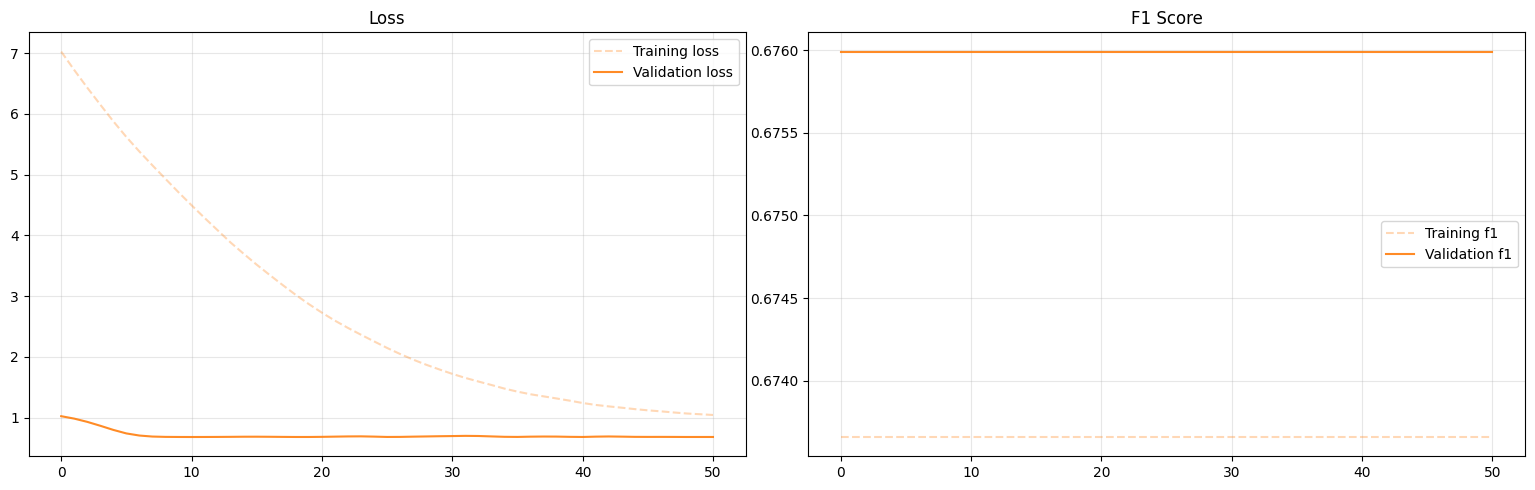

In [156]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()